# The Movie Data Base Use Case. Challenge Task 
### Master Advanced Analytics on Big Data. Module 5. Use case I
#### Author: Alonso Andrade Blázquez (aandradeblazquez@gmail.com)

Created on:

In [11]:
from datetime import datetime

str(datetime.now())

'2018-04-17 19:01:55.774961'

## 0. Introduction

### Task statement

The objective of this challenge is to implement a Jupyter "notebook" in Python based on actual available Open Data repositories that you would select. The goal is to prepare a notebook with some clear steps: data load, store and querying with mongo, data processing and curation, visualization and conclusions). This notebook should have similar dimension and contents to those developed for "San Francisco Crime” and "OKCupid”.

The steps to proceed would be as follows:
- Setting out the notebook motivations, domain and target
- Identify the required source/s of data, links, formats, etc.
- Implement the notebook identifying clear steps and including clear explanations of each analysis

### Importing required packages

In [203]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
# import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import HTML
import json

import sys
sys.path.insert(0,'..')
import folium
print (folium.__file__)
print (folium.__version__)
from matplotlib.colors import Normalize, rgb2hex
from IPython.display import display

import pymongo
from pymongo import MongoClient, GEO2D

import folium
import numpy as np
from folium.plugins import MarkerCluster # for marker clusters
from folium.plugins import HeatMap
from folium import plugins
from folium.plugins import HeatMapWithTime
import datetime
from datetime import datetime, date, time

import ast
from pandas.io.json import json_normalize

pd.set_option('display.max_colwidth', 0)

C:\ProgramData\Anaconda3\lib\site-packages\folium\__init__.py
0.5.0


## 1. Import data to MongoDB

For this task, we selected **MovieLens** dataset, including 45000+ movies information from TMDB (The Movie Data Base) webpage. It is composed by the different files shown below:
- *movies_metadata.csv*
- *credits.csv*
- *keywords.csv*

Firstle, let's load these files to MongoDB to work with it in the rest of the task:

In [13]:
# Check MongoDB version installed in the OS
print('Mongo version', pymongo.__version__)

# Set MongoDB client
client = MongoClient('localhost', 27017)

# Set MongoDB database
database_name = 'UseCaseI-MovieLens'
db = client[database_name]

Mongo version 3.6.1


**Collection movies_metadata**

In [14]:
collection_metadata = db['movies_metadata']
collection_metadata.drop()

In [15]:
# MongoBD import from csv file
os.system('"C:\\Program Files\\MongoDB\\Server\\3.4\\bin\\mongoimport" \
            -d UseCaseI-MovieLens -c movies_metadata \
            --type csv \
            --file C:\\Users\\Alonso\\Desktop\\casoUso1\\ChallengeTask\\movies_metadata.csv \
            --headerline')

0

In [143]:
query_movies_metadata = collection_metadata.find()
print(query_movies_metadata[0])

{'_id': ObjectId('5ad62886cfa732ff7167ed5a'), 'adult': 'False', 'belongs_to_collection': "{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}", 'budget': 30000000, 'genres': "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]", 'homepage': 'http://toystory.disney.com/toy-story', 'id': 862, 'imdb_id': 'tt0114709', 'original_language': 'en', 'original_title': 'Toy Story', 'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.", 'popularity': 21.946943, 'poster_path': '/rhIRbceoE9lR4veEXuwCC2wARtG.jpg', 'production_companies': "[{'name': 'Pixar Animation Studios', 'id': 3}]", 'production_co

In [17]:
query_movies_metadata_count = collection_metadata.find().count()
query_movies_metadata_count

45466

**Collection keywords**

In [18]:
collection_keywords = db['keywords']
collection_keywords.drop()

In [19]:
# MongoBD import from csv file
os.system('"C:\\Program Files\\MongoDB\\Server\\3.4\\bin\\mongoimport" \
            -d UseCaseI-MovieLens -c keywords \
            --type csv \
            --file C:\\Users\\Alonso\\Desktop\\casoUso1\\ChallengeTask\\keywords.csv \
            --headerline')

0

In [189]:
query_keywords = collection_keywords.find()
query_keywords[0]

{'_id': ObjectId('5ad6288bcfa732ff71689f2a'),
 'id': 862,
 'keywords': "[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"}

In [24]:
query_keywords_count = collection_keywords.find().count()
query_keywords_count

46419

**Collection credits**

In [26]:
collection_credits = db['credits']
collection_credits.drop()

In [27]:
# MongoBD import from csv file
os.system('"C:\\Program Files\\MongoDB\\Server\\3.4\\bin\\mongoimport" \
            -d UseCaseI-MovieLens -c credits \
            --type csv \
            --file C:\\Users\\Alonso\\Desktop\\casoUso1\\ChallengeTask\\credits.csv \
            --headerline')

0

In [210]:
query_credits = collection_credits.find()
print(query_credits[0])

{'_id': ObjectId('5ad628fecfa732ff716954c0'), 'cast': "[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Walla

In [29]:
query_credits_count = collection_credits.find().count()
query_credits_count

45476

## 2. Dataset description

Let's use pandas with the data previously stored in MongoDB to explore the datasets:

**Collection movies_metadata**

In [30]:
movies_metadata_df = pd.DataFrame(list(query_movies_metadata))

In [208]:
display(movies_metadata_df.head(1))

,_id,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year,release_month
0,5ad62886cfa732ff7167ed5a,False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,10


1227582


As we see above, **movies_metadata** contains the main interesting information about the titles in the dataset. It contains **25 features** about each movie.

List of features:

In [32]:
list(movies_metadata_df)

['_id',
 'adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

**Collection keywords**

In [33]:
keywords_df = pd.DataFrame(list(query_keywords))

In [34]:
display(keywords_df.head(1))

,_id,id,keywords
0,5ad6288bcfa732ff71689f2a,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"


**keywords** contains tags for each movie, what make it easier to make groups of movies with the same topics. It is linked to movies_metadata by the field 'id'.

In [35]:
list(keywords_df)

['_id', 'id', 'keywords']

**Collection credits**

In [36]:
credits_df = pd.DataFrame(list(query_credits))

In [37]:
display(credits_df.head(1))

_id  \
0  5ad628fecfa732ff716954c0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg'}, {'cast_id': 19, 'character': 'Hamm (voice)', 'credit_id': '52fe4284c3a36847f8024fa9', 'gender': 2, 'id': 7907, 'name': 'John Ratzenberger', 'order': 5, 'profile_path': '/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg'}, {'cast_id': 20, 'character': 'Bo Peep (voice)', 'credit_id': '52fe4284c3a36847f8024fad', 'gen

**credits** contains all the information for the cast-crew of every movie, linked by the movie id field.

In [38]:
list(credits_df)

['_id', 'cast', 'crew', 'id']

## 3. Data analysis

Below we will perform an **exploratory data analysis** to get insights about the cinema history.

### What are the 25 most remaked movies?

In Hollywood is more and more common to remake movies previously filmed instead of creating new stories. What are the stories more remaked in the history?

In [39]:
most_remaked = movies_metadata_df.groupby('title').size().sort_values(ascending=False)[:25]
most_remaked

title
Cinderella                       11
Alice in Wonderland              9 
Hamlet                           9 
Beauty and the Beast             8 
Les Misérables                   8 
Blackout                         7 
Treasure Island                  7 
The Three Musketeers             7 
A Christmas Carol                7 
Wuthering Heights                6 
Countdown                        6 
The Hunters                      6 
King Lear                        6 
The Journey                      6 
The Circle                       6 
Mother                           6 
Love                             6 
The Hound of the Baskervilles    6 
The Promise                      6 
First Love                       6 
Home                             6 
Macbeth                          6 
Jane Eyre                        6 
The Stranger                     6 
The Forest                       6 
dtype: int64

And the winner is...

![cinderella](pictures/cinderella.png)

We can see that classics of literature are the most remaked, like *Cinderella*, *Alice in Wonderland* or *Hamlet*. Shakespeare is also present more times in this list.

Note: maybe some remakes are out of this list if the responsibles decided to change the movie title for the remake.

### What are the 25 most voted movies?

In [40]:
most_voted = movies_metadata_df.sort_values('vote_count', ascending=False)[:25]
most_voted[['title', 'vote_count']]

,title,vote_count
15477,Inception,14075.0
12481,The Dark Knight,12269.0
14557,Avatar,12114.0
17815,The Avengers,12000.0
26564,Deadpool,11444.0
22879,Interstellar,11187.0
20051,Django Unchained,10297.0
23753,Guardians of the Galaxy,10014.0
2861,Fight Club,9678.0
18243,The Hunger Games,9634.0


And the winner is...

![inception](pictures/inception.png)

Here we can see that millennials have something to say in this list, as Christopher Nolan is in the top with 2 movies (*Inception* and *The dark knight*), so hype is an important factor when reviewing movies. *Avatar*, from another blockbuster expert (James Cameron) follows Nolan in the list. We can see that Tarantino is very well-known by the users voting in the internet, as he has several of his movies in this list.

### What are the 25 movies with the highest average rating?

In [41]:
above_1000_votes = movies_metadata_df['vote_count'] >= 1000
highest_rated = movies_metadata_df[above_1000_votes].sort_values('vote_average', ascending=False)[:25]
highest_rated[['title', 'vote_average', 'vote_count']]

,title,vote_average,vote_count
831,The Godfather,8.5,6024.0
40251,Your Name.,8.5,1030.0
311,The Shawshank Redemption,8.5,8358.0
292,Pulp Fiction,8.3,8670.0
1173,Psycho,8.3,2405.0
2211,Life Is Beautiful,8.3,3643.0
5478,Spirited Away,8.3,3968.0
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0
1175,The Godfather: Part II,8.3,3418.0
12481,The Dark Knight,8.3,12269.0


And the winner is...

![godfather](pictures/godfather.png)

For this list we considered movies with more than 1000 votes, as there are movies in the dataset voted by a few people with a non-realistic high score (maybe trolls). 

It is not a surprise that a classic like *The godfather* is in the top of this list, followed by a movie that increased its popularity over the years, *The Shawshank Redemption*. It is a surprise to see japanese anime *Your name* in the third position.

### What are the 25 movies with the highest box-office revenue?

In [42]:
pd.set_option('display.precision',11)
highest_box_office = movies_metadata_df.sort_values('revenue', ascending=False)[:25]
highest_box_office[['title', 'revenue']]

,title,revenue
14557,Avatar,2787965087.0
26562,Star Wars: The Force Awakens,2068223624.0
1640,Titanic,1845034188.0
17815,The Avengers,1519557910.0
25084,Jurassic World,1513528810.0
28830,Furious 7,1506249360.0
26555,Avengers: Age of Ultron,1405403694.0
17437,Harry Potter and the Deathly Hallows: Part 2,1342000000.0
22107,Frozen,1274219009.0
42223,Beauty and the Beast,1262886337.0


And the winner is...

![avatar](pictures/avatar.png)

Here we can see that Cameron with his *Avatar* is leading the list, having also *Titanic* in the third position, what makes him probably the most successful director in Hollywood. The second place is for *Star wars: the force awakens*, which indicates that nostalgia plays an important role nowadays in cinema (a similar case is *Jurassic world*). It is bizarre that several movies of the saga *The fast and the furious* are in this list, but it can be understandable if we remember that we are in raegetton era. 

### What are the 25 most expensive movies?

We must convert ``budget`` to number to use it for this query.

In [44]:
# Parse object to number
# Data cleaning: there are some leters in 'budget' column. With errors='coerce' we can convert them to 'null'.
movies_metadata_df['budget'] = pd.to_numeric(movies_metadata_df['budget'], errors = 'coerce')

In [45]:
most_expensive = movies_metadata_df.sort_values('budget', ascending=False)[:25]
most_expensive[['title', 'budget']]

,title,budget
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0
11827,Pirates of the Caribbean: At World's End,300000000.0
26555,Avengers: Age of Ultron,280000000.0
11067,Superman Returns,270000000.0
16130,Tangled,260000000.0
18685,John Carter,260000000.0
44842,Transformers: The Last Knight,260000000.0
11780,Spider-Man 3,258000000.0
21175,The Lone Ranger,255000000.0
25390,The Hobbit: The Battle of the Five Armies,250000000.0


And the winner is...

![pirates](pictures/pirates.png)

Above we can see that two of the movies from *Pirates of the Caribbean* saga are in the top of this list, as the studio invested a lot of money after the successfully first trilogy. After those movies some superhero ones are in the first positions of the list.

Note: inflation is not considered in this list.

### How many movies were released by year?

Information included in the dataset about time is the release day of each movie:

In [46]:
movies_metadata_df['release_date'].head(1)

0    1995-10-30
Name: release_date, dtype: object

For this analysis, let's append new columns for month and year release. For that purpose, we must convert ``release_date`` column to ``datetime`` format first:

In [47]:
# Parse release_date field to date type
movies_metadata_df['release_date'] = pd.to_datetime(movies_metadata_df['release_date'], errors='coerce')

# New columns with year and month release
movies_metadata_df['release_year'] = movies_metadata_df['release_date'] \
                                        .apply(lambda time: time.year) \
                                        .fillna(0) \
                                        .astype(np.int64) 
            
movies_metadata_df['release_month'] = movies_metadata_df['release_date'] \
                                        .apply(lambda time: time.month) \
                                        .fillna(0) \
                                        .astype(np.int64)

In [48]:
display(movies_metadata_df["release_year"].head(2))
display(movies_metadata_df["release_month"].head(2))

0    1995
1    1995
Name: release_year, dtype: int64

0    10
1    12
Name: release_month, dtype: int64

In [49]:
movies_per_year = movies_metadata_df.groupby('release_year').size().sort_values(ascending=False)[:50]
movies_per_year

release_year
2014    1974
2015    1905
2013    1889
2012    1722
2011    1667
2016    1604
2009    1586
2010    1501
2008    1473
2007    1320
2006    1270
2005    1125
2004    992 
2002    905 
2003    882 
2001    865 
2000    789 
1999    723 
1998    722 
1997    661 
1996    633 
1995    599 
1994    544 
2017    532 
1993    489 
1988    467 
1987    462 
1992    453 
1989    439 
1990    427 
1991    426 
1986    391 
1972    381 
1971    378 
1985    368 
1982    368 
1984    362 
1980    361 
1981    360 
1973    356 
1970    354 
1983    353 
1974    348 
1979    338 
1968    338 
1977    334 
1976    333 
1975    332 
1978    321 
1966    306 
dtype: int64

Text(0,0.5,'Number of films')

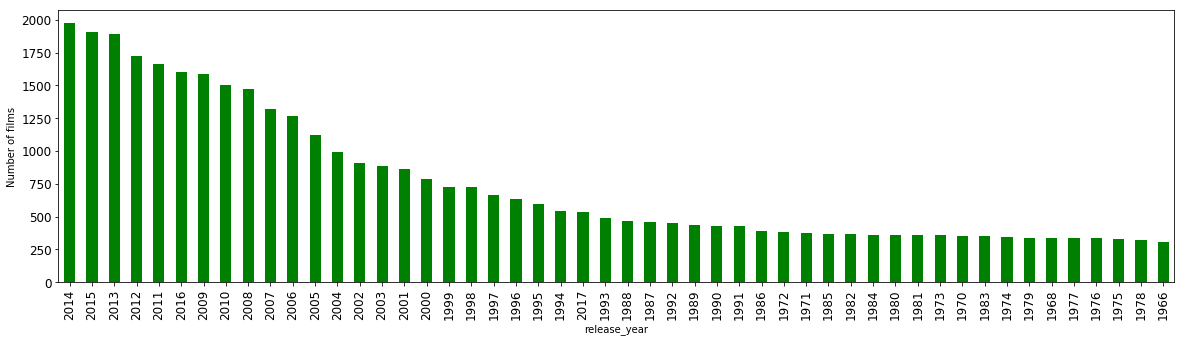

In [50]:
fig = plt.figure(figsize = (20, 5))
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 4)
movies_per_year.plot(kind ='bar', fontsize = 12, color = 'g')
plt.xlabel('release_year')
plt.ylabel('Number of films', fontsize = 10)

Above we can see that 2000 till nowadays is the range with more released movies, followed by 90's. 2017 is not at the top because at the time of building this dataset that year was not finished.

### What are the months with more released movies?

In [51]:
movies_per_month = movies_metadata_df.groupby('release_month').size().sort_values(ascending=False)[:12]
movies_per_month

release_month
1     5915
9     4838
10    4615
12    3786
11    3661
3     3553
4     3453
8     3394
5     3339
6     3153
2     3032
7     2640
dtype: int64

Text(0,0.5,'Number of films')

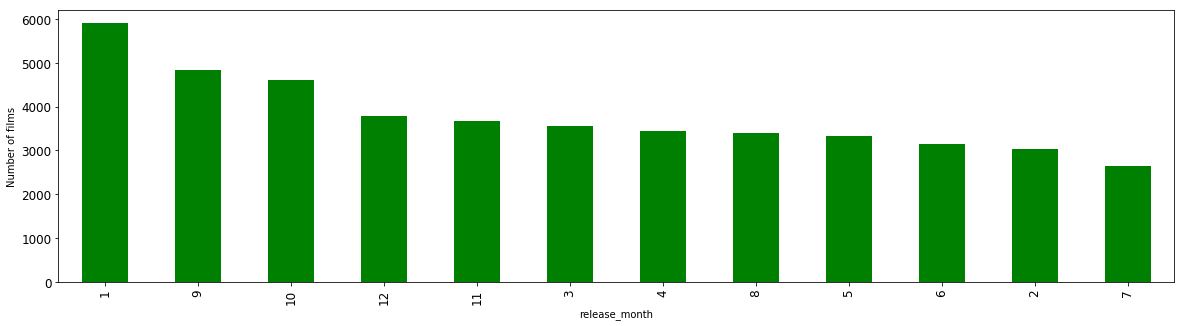

In [52]:
fig = plt.figure(figsize = (20, 5))
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 4)
movies_per_month.plot(kind ='bar', fontsize = 12, color = 'g')
plt.xlabel('release_month')
plt.ylabel('Number of films', fontsize = 10)

Here we can see that january is the month with the highest rate of released film, this is typical due to it is Christmas time and hence holidays. September, as it is the end of Summer, is also a month with a high rate of releases.

### What are the most popular genres?

To perform this query, we must access ``genres`` category. As we can see below, ``genres`` contains a **``string``** and an array inside, what makes very difficult to access the values within. To solve this problem, we can use ``literal_eval`` function from ``ast`` library, in order to evaluate the value within the quotes:

In [206]:
print(query_movies_metadata[0])

{'_id': ObjectId('5ad62886cfa732ff7167ed5a'), 'adult': 'False', 'belongs_to_collection': "{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}", 'budget': 30000000, 'genres': "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]", 'homepage': 'http://toystory.disney.com/toy-story', 'id': 862, 'imdb_id': 'tt0114709', 'original_language': 'en', 'original_title': 'Toy Story', 'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.", 'popularity': 21.946943, 'poster_path': '/rhIRbceoE9lR4veEXuwCC2wARtG.jpg', 'production_companies': "[{'name': 'Pixar Animation Studios', 'id': 3}]", 'production_co

In [144]:
movies_metadata_df['genres'] = [ast.literal_eval(x) for x in movies_metadata_df['genres']]

Now we must use another pandas function, **``pd.io.json_normalize``**, in order to convert the contents within a json array into a pandas dataframe:

In [ ]:
df_array = []
                         
for doc in movies_metadata_df['genres']:
    newRecord = pd.io.json.json_normalize(doc)
    df_array.append(newRecord)

genres = pd.concat(df_array)

In [168]:
genres.head()

,id,name
0,16,Animation
1,35,Comedy
2,10751,Family
0,10749,Romance
1,35,Comedy


Now we can manage the genres for our purposes:

In [178]:
popular_genres = genres.groupby('name').size().sort_values(ascending=False)[:25]
popular_genres

name
Drama                                    20265
Comedy                                   13182
Thriller                                 7624 
Romance                                  6735 
Action                                   6596 
Horror                                   4673 
Crime                                    4307 
Documentary                              3932 
Adventure                                3496 
Science Fiction                          3049 
Family                                   2770 
Mystery                                  2467 
Fantasy                                  2313 
Animation                                1935 
Foreign                                  1622 
Music                                    1598 
History                                  1398 
War                                      1323 
Western                                  1042 
TV Movie                                 767  
Sentai Filmworks                         1    
GoHands 

As we can see, the most popular genre in cinema history is drama, followed by comedy and thriller.

Let's plot this in a fancy way:

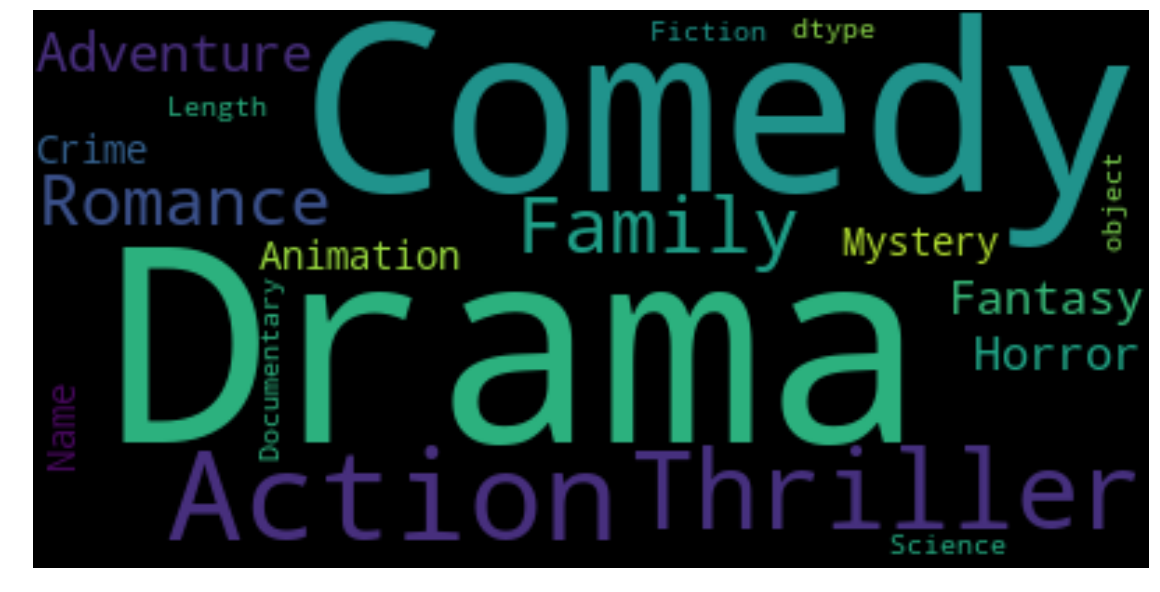

In [187]:
# Libraries
from wordcloud import WordCloud
 
# Create the wordcloud object
wordcloud2 = WordCloud().generate(str(genres['name']))

# Display the generated image:
plt.figure(figsize=(20,20))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### What are the most popular topics in movies?

Here we can take a look to another collection, **``keywords``**. Let's perform a similar action as with the previous query:

In [190]:
print(query_keywords[0])

{'_id': ObjectId('5ad6288bcfa732ff71689f2a'), 'id': 862, 'keywords': "[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"}


In [192]:
keywords_df['keywords'] = [ast.literal_eval(x) for x in keywords_df['keywords']]

In [194]:
df_array_keywords = []
                         
for doc in keywords_df['keywords']:
    newRecord = pd.io.json.json_normalize(doc)
    df_array_keywords.append(newRecord)

keywords = pd.concat(df_array_keywords)

In [195]:
keywords.head()

,id,name
0,931,jealousy
1,4290,toy
2,5202,boy
3,6054,friendship
4,9713,friends


In [199]:
popular_keywords = keywords.groupby('name').size().sort_values(ascending=False)[:50]
popular_keywords

name
woman director          3115
independent film        1930
murder                  1308
based on novel          835 
musical                 734 
sex                     685 
violence                651 
nudity                  636 
biography               629 
revenge                 626 
suspense                590 
love                    574 
female nudity           563 
sport                   544 
police                  454 
teenager                441 
duringcreditsstinger    440 
sequel                  439 
friendship              411 
world war ii            394 
drug                    360 
prison                  351 
stand-up comedy         351 
high school             319 
martial arts            314 
suicide                 312 
silent film             306 
rape                    306 
kidnapping              306 
film noir               305 
family                  295 
serial killer           293 
monster                 285 
alien                   283 
dystopia 

As we can see above, woman director is the most tagged topic in the movies. This is strange, but explanation is that male directors are not never tagged (in fact it gives information about the small quantity of movies directed by women). A similar case are the independent films. After those outliers, first in list is murder, so it indicates that is an engaging topic in cinema, followed by "based on a novel" adaptations.

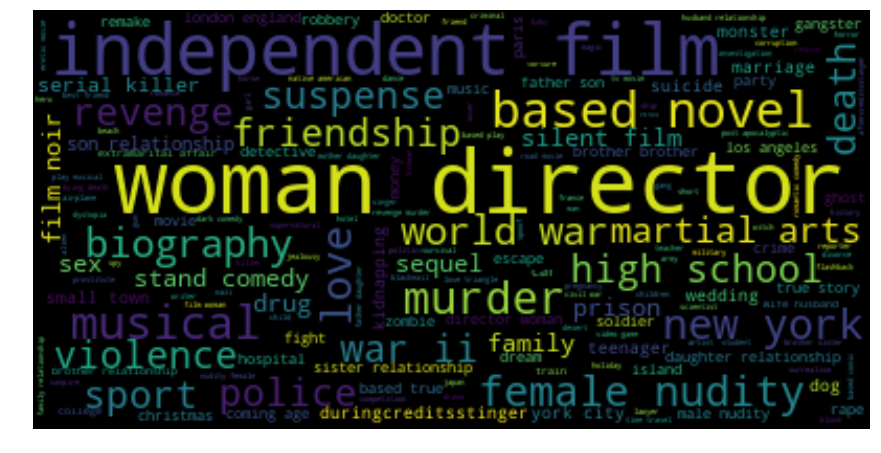

In [202]:
# Libraries
from wordcloud import WordCloud
 
# Create the wordcloud object
wordcloud = WordCloud().generate(' '.join(keywords['name']))
# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### What is the director who made more movies?

Here we can take a look to another collection, **``credits``**. Let's perform a similar action as with the previous query:

In [211]:
print(query_credits[0])

{'_id': ObjectId('5ad628fecfa732ff716954c0'), 'cast': "[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Walla

In [217]:
credits_df['crew'] = [ast.literal_eval(x) for x in credits_df['crew']]

In [213]:
credits_df.head(1)

_id  \
0  5ad628fecfa732ff716954c0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg'}, {'cast_id': 19, 'character': 'Hamm (voice)', 'credit_id': '52fe4284c3a36847f8024fa9', 'gender': 2, 'id': 7907, 'name': 'John Ratzenberger', 'order': 5, 'profile_path': '/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg'}, {'cast_id': 20, 'character': 'Bo Peep (voice)', 'credit_id': '52fe4284c3a36847f8024fad', 'gen

In [215]:
credits_df['crew'][0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

In [218]:
df_array_credits = []
                         
for doc in credits_df['crew']:
    newRecord = pd.io.json.json_normalize(doc)
    df_array_credits.append(newRecord)

crew = pd.concat(df_array_credits)

In [219]:
crew.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


In [223]:
directing_department = crew['department'] == "Directing"
directors = crew[directing_department]
directors.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
25,589213d39251412dc8009832,Directing,0,1748707,Layout,Roman Figun,None
82,589213e2c3a3680973009026,Directing,0,1748709,Layout,Desirée Mourad,None
3,52fe44bfc3a36847f80a7c7d,Directing,2,4945,Director,Joe Johnston,/fok4jaO62v5IP6hkpaaAcXuw2H.jpg
0,52fe466a9251416c75077a89,Directing,2,26502,Director,Howard Deutch,/68Vae1HkU1NxQZ6KEmuxIpno7c9.jpg


In [224]:
directors_with_more_movies = directors.groupby('name').size().sort_values(ascending=False)[:25]
directors_with_more_movies

name
John Ford             68
Michael Curtiz        65
Werner Herzog         55
Alfred Hitchcock      53
Georges Méliès        51
Jean-Luc Godard       50
Woody Allen           49
Sidney Lumet          46
Henry Hathaway        46
William A. Wellman    44
Raoul Walsh           44
Charlie Chaplin       44
Martin Scorsese       42
Richard Thorpe        42
Ingmar Bergman        40
George Cukor          40
John Huston           39
Fritz Lang            38
Robert Altman         38
Mervyn LeRoy          38
Frank Capra           37
Claude Chabrol        37
Takashi Miike         37
W.S. Van Dyke         37
Robert Wise           37
dtype: int64

And the winner is...

![johnford](pictures/johnford.png)

John Ford is the director who made more movies in known history. Woody Allen, still in active, is other name in the first positions of this list.

### What are the actors / actresses with more performances?

In [233]:
credits_df['cast'] = [ast.literal_eval(x) for x in credits_df['cast']]

In [234]:
credits_df.head(1)

_id  \
0  5ad628fecfa732ff716954c0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg'}, {'cast_id': 19, 'character': 'Hamm (voice)', 'credit_id': '52fe4284c3a36847f8024fa9', 'gender': 2, 'id': 7907, 'name': 'John Ratzenberger', 'order': 5, 'profile_path': '/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg'}, {'cast_id': 20, 'character': 'Bo Peep (voice)', 'credit_id': '52fe4284c3a36847f8024fad', 'gen

In [235]:
credits_df['cast'][0]

[{'cast_id': 14,
  'character': 'Woody (voice)',
  'credit_id': '52fe4284c3a36847f8024f95',
  'gender': 2,
  'id': 31,
  'name': 'Tom Hanks',
  'order': 0,
  'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'},
 {'cast_id': 15,
  'character': 'Buzz Lightyear (voice)',
  'credit_id': '52fe4284c3a36847f8024f99',
  'gender': 2,
  'id': 12898,
  'name': 'Tim Allen',
  'order': 1,
  'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
 {'cast_id': 16,
  'character': 'Mr. Potato Head (voice)',
  'credit_id': '52fe4284c3a36847f8024f9d',
  'gender': 2,
  'id': 7167,
  'name': 'Don Rickles',
  'order': 2,
  'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'},
 {'cast_id': 17,
  'character': 'Slinky Dog (voice)',
  'credit_id': '52fe4284c3a36847f8024fa1',
  'gender': 2,
  'id': 12899,
  'name': 'Jim Varney',
  'order': 3,
  'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'},
 {'cast_id': 18,
  'character': 'Rex (voice)',
  'credit_id': '52fe4284c3a36847f8024fa5',
  'gender': 2,
  'id': 12900,
 

In [236]:
df_array_credits = []
                         
for doc in credits_df['cast']:
    newRecord = pd.io.json.json_normalize(doc)
    df_array_credits.append(newRecord)

cast = pd.concat(df_array_credits)

In [239]:
cast.head(7)

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg
5,19,Hamm (voice),52fe4284c3a36847f8024fa9,2,7907,John Ratzenberger,5,/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg
6,20,Bo Peep (voice),52fe4284c3a36847f8024fad,1,8873,Annie Potts,6,/eryXT84RL41jHSJcMy4kS3u9y6w.jpg


In [241]:
actors = cast['gender'] == 2
male_actors = cast[actors]
male_actors.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


In [242]:
actors_with_more_movies = male_actors.groupby('name').size().sort_values(ascending=False)[:25]
actors_with_more_movies

name
Christopher Lee       148
John Wayne            125
Samuel L. Jackson     123
Gérard Depardieu      110
Michael Caine         110
Donald Sutherland     109
John Carradine        109
Jackie Chan           108
Frank Welker          107
Robert De Niro        104
Danny Trejo           102
Steve Buscemi         101
Irving Bacon          98 
John Goodman          97 
Christopher Walken    96 
Danny Glover          96 
Dennis Hopper         94 
John Hurt             93 
Eric Roberts          92 
Bruce Willis          91 
Harvey Keitel         91 
Malcolm McDowell      90 
Willem Dafoe          89 
Anthony Quinn         88 
Donald Pleasence      87 
dtype: int64

And the winner is...

![christopherlee](pictures/christopherlee.png)
Mythical Christopher Lee is the actor with the biggest amount of movies, followed by John Wayne.It's surprising that Samuel L. Jackson have made so many pictures in his (still active) career.

Let's do the same with the actresses:

In [243]:
actresses = cast['gender'] == 1
female_actresses = cast[actresses]
female_actresses.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
6,20,Bo Peep (voice),52fe4284c3a36847f8024fad,1,8873,Annie Potts,6,/eryXT84RL41jHSJcMy4kS3u9y6w.jpg
9,23,Mrs. Davis (voice),52fe4284c3a36847f8024fb5,1,12133,Laurie Metcalf,9,/unMMIT60eoBM2sN2nyR7EZ2BvvD.jpg
11,25,Hannah (voice),52fe4284c3a36847f8024fbd,1,12903,Sarah Freeman,11,None
2,2,Judy Sheperd,52fe44bfc3a36847f80a7c77,1,205,Kirsten Dunst,2,/wBXvh6PJd0IUVNpvatPC1kzuHtm.jpg
4,10,Sarah Whittle,52fe44bfc3a36847f80a7c9d,1,5149,Bonnie Hunt,4,/7spiVQwmr8siw5QCcvvdRG3c7Lf.jpg


In [244]:
actresses_with_more_movies = female_actresses.groupby('name').size().sort_values(ascending=False)[:25]
actresses_with_more_movies

name
Bess Flowers          241
Susan Sarandon        93 
Whoopi Goldberg       85 
Helen Mirren          75 
Bette Davis           75 
Bruce Dern            71 
Grey Griffin          71 
Vanessa Redgrave      70 
Shelley Winters       67 
Sigourney Weaver      67 
Catherine Deneuve     67 
Isabelle Huppert      66 
Julianne Moore        66 
Meryl Streep          66 
Kathy Bates           64 
Barbara Stanwyck      63 
Cloris Leachman       62 
Geraldine Chaplin     62 
Joan Crawford         62 
Charlotte Rampling    61 
Lin Shaye             61 
Mary Steenburgen      61 
Nicole Kidman         60 
Beth Grant            60 
Anjelica Huston       59 
dtype: int64

And the winner is...

![bessflowers](pictures/bessflowes.png)

Bess Flowers, followed by Susan Sarandon, are the actresses with more movies in the list.